In [1]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_relaxation

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 72
plt.rcParams["figure.figsize"] = [12,8]

from ising_model import Simulate_MH

In [2]:
%%timeit
_,_,Ms, Es, engine = to_run(1, 1_000_000, T=0.1, N=32, freq=1, 
                            SEED=15, return_engine=True, 
                            init="random")

88 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
pool = Pool(7)

In [4]:
scale = 100
times = 100

# Ts = np.concatenate([
#     np.linspace(0,1.8,scale),
#     np.linspace(1.8,3.5,5*scale),
#     np.linspace(3.5,6,scale),
# ])

Ts = [np.linspace(0,4.5,scale+1)[1:]]*times

results = []
for Ts1 in tqdm(Ts):
    runs = len(Ts1)
    res = pool.starmap(find_relaxation, #T, N, steps, SEED
            zip(*(Ts1,
                  [32]*runs, # N
                  [1000_000]*runs, # steps
                  np.random.randint(0,1000000, runs), # seed
                      )),
#             chunksize=1
        )
    results+= res

In [ ]:
def findpos(x, start=0):
    def findpos_rec(x, start=0):
        x1 = x[start:]

        mean = np.mean(x1)
        std = np.mean(x1)
        if mean < x[0]:
            mean = - mean
            x = -x
            x1 = -x1
        x2 = x1[x1>=mean]
        mean2 = np.mean(x2)

        #         print(np.where(x>mean2))
        return np.where(x>=mean2)[0][0]
    pos = [0]
    for _ in range(400):
        pos.append(findpos_rec(x, start=pos[-1]))
        if pos[-1]==pos[-2]:
            break
    return pos[-1]

In [5]:
df = pd.DataFrame(results, columns=["T",  "RTM_const", "RTE_const", "RTM_rand", "RTE_rand"])

In [6]:
gb = df.groupby("T")

In [7]:
dfmoments = pd.concat([
gb.mean().add_suffix("_mean"),
gb.std().add_suffix("_std")], axis=1)
dfm = dfmoments[sorted(dfmoments.columns)]

In [8]:
dfm

,RTE_const_mean,RTE_const_std,RTE_rand_mean,RTE_rand_std,RTM_const_mean,RTM_const_std,RTM_rand_mean,RTM_rand_std
T,,,,,,,,
0.045,0.00,0.000000,164818.68,87761.865105,0.00,0.000000,113333.40,93098.594316
0.090,0.00,0.000000,153251.80,103415.007785,0.00,0.000000,109518.92,90384.107850
0.135,0.00,0.000000,166772.94,103735.190593,0.00,0.000000,121569.15,101127.752260
0.180,0.00,0.000000,141896.73,70384.231601,0.00,0.000000,112869.09,79578.801031
0.225,0.00,0.000000,153305.22,100931.709485,0.00,0.000000,105686.13,100862.642646
...,...,...,...,...,...,...,...,...
4.320,6589.96,1967.804586,3447.90,1888.674146,15473.21,7551.767528,6376.21,7676.005581
4.365,6250.32,1796.820232,3440.87,1609.708429,14331.61,5999.883458,5478.07,5508.175515
4.410,6049.83,1701.298453,3352.63,1703.780743,13471.00,6365.842888,5078.48,5063.800656


In [97]:
sprs = 1/3

In [ ]:
0..2.2 -- 3000000


In [102]:
steps = np.ones_like(Ts1)*10**5
b=0.08
n=0.1
steps = np.exp(np.log(3*10**6)*(b/(b+Ts1-2.5))**n)
steps[Ts1<2.5] = 3*10**6
steps = steps.astype(int)

<ipython-input-102-f1d4919c608c>:4: RuntimeWarning: invalid value encountered in power
  steps = np.exp(np.log(3*10**6)*(b/(b+Ts1-2.5))**n)


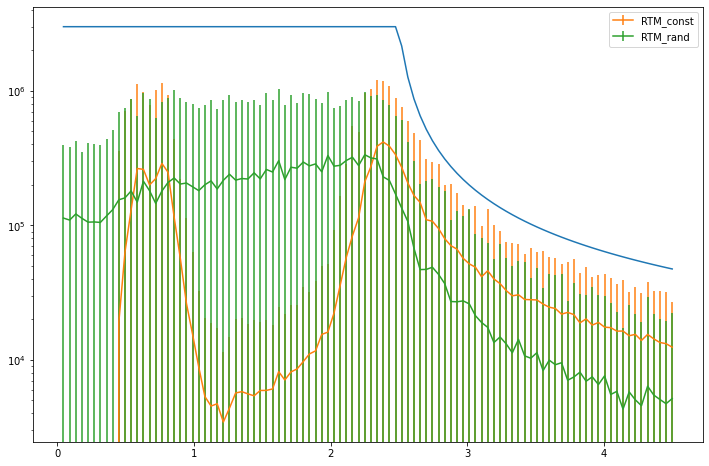

In [103]:
plt.plot(dfm.index, steps)
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log", base=10)
plt.legend()

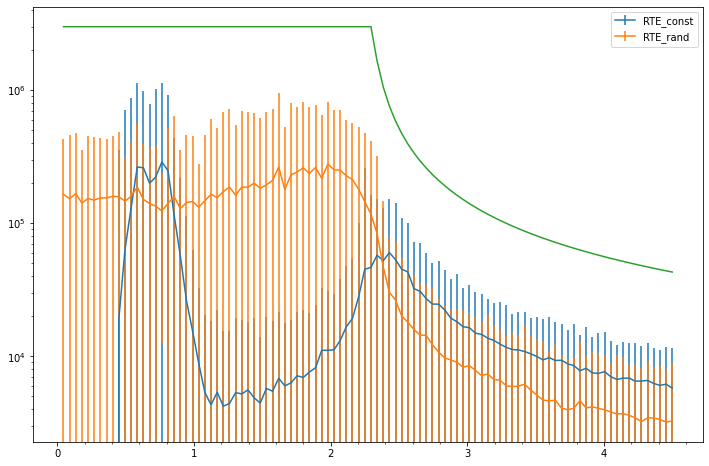

In [98]:
plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.plot(dfm.index, steps)
plt.gca().set_yscale("log", base=10)
plt.legend()
plt.minorticks_on()

In [148]:
Mss_rand  = []
Mss_const = []
Ess_rand  = []
Ess_const = []
T = 0.4
steps = 1_00_000

for _ in tqdm(range(10)):
    SEED = np.random.randint(100000000)
    _,_,Ms, Es, engine = to_run(1, steps, T=T, N=32, freq=max(1,steps//10**5), 
                            SEED=SEED, return_engine=True, 
                            init="random")
    Mss_rand.append(Ms)
    Ess_rand.append(Es)
    
    SEED = np.random.randint(100000000)
    _,_,Ms, Es, engine = to_run(1, steps, T=T, N=32, freq=max(1,steps//10**5), 
                            SEED=SEED, return_engine=True, 
                            init="constant")
    Mss_const.append(Ms)
    Ess_const.append(Es)
    

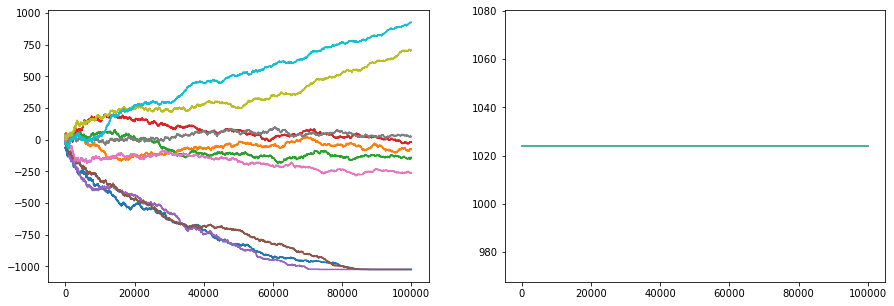

In [161]:
till=-1#1000
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.array(Mss_rand).T[:till]);
plt.subplot(122)
plt.plot(np.array(Mss_const).T[:till]);

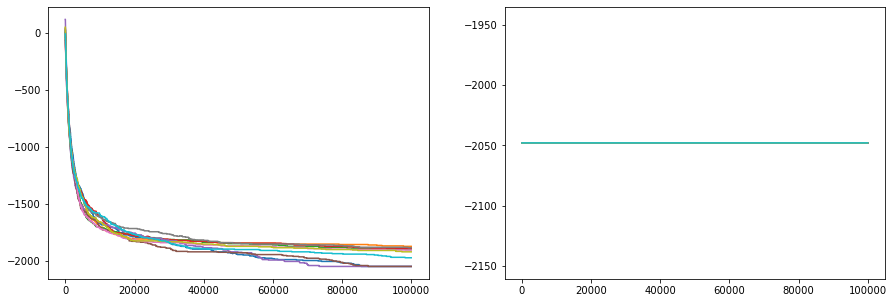

In [162]:
till=-1#1000
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.array(Ess_rand).T[:till]);
plt.subplot(122)
plt.plot(np.array(Ess_const).T[:till]);

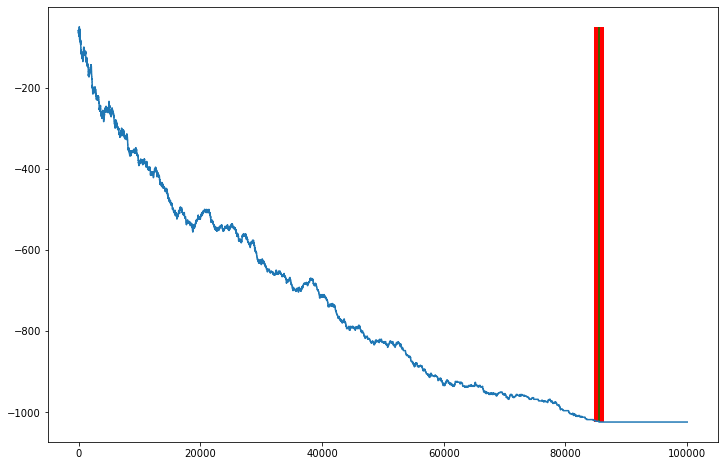

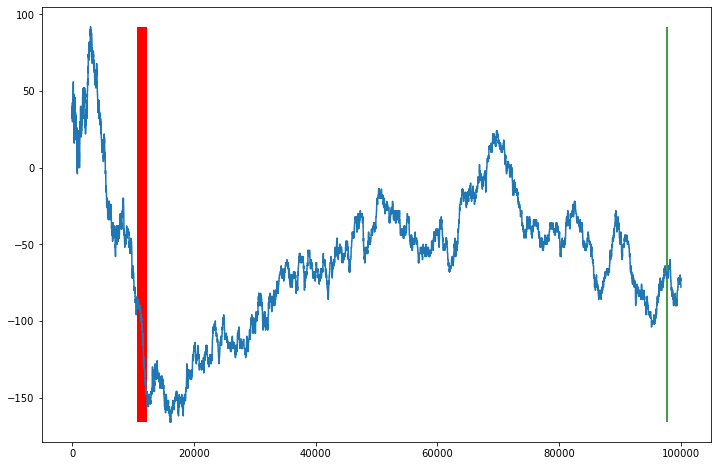

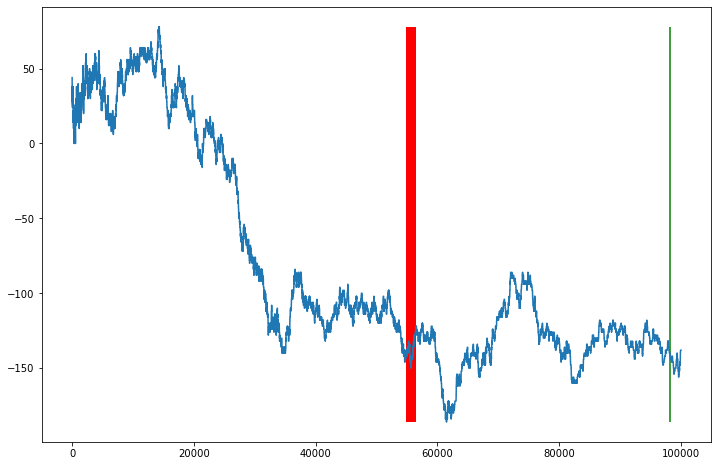

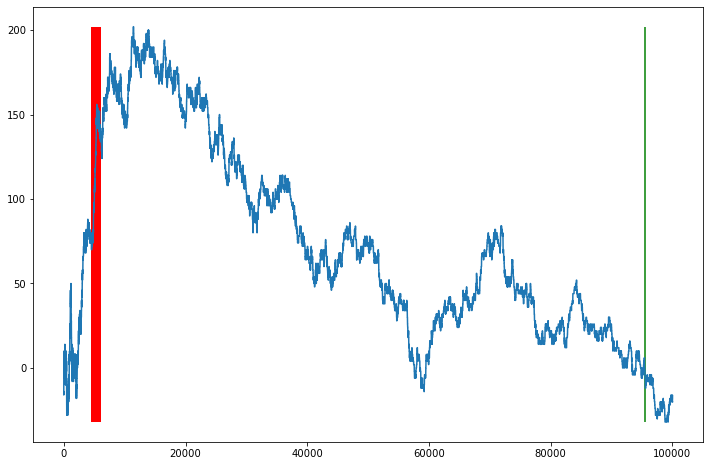

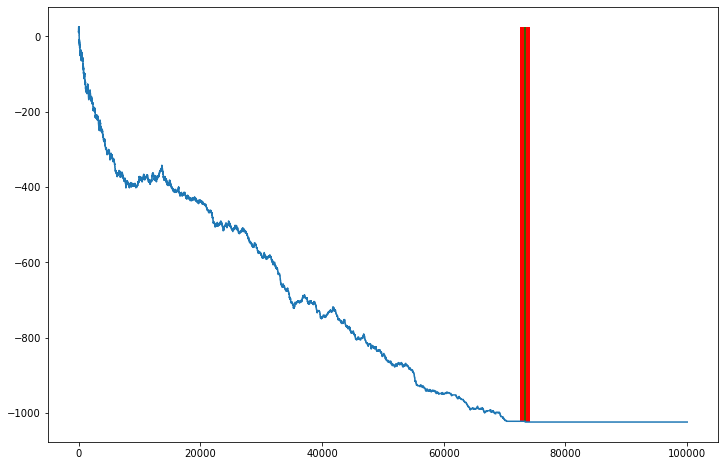

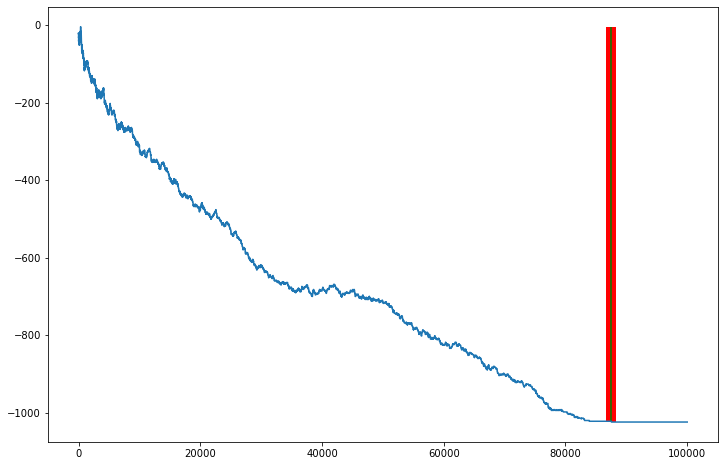

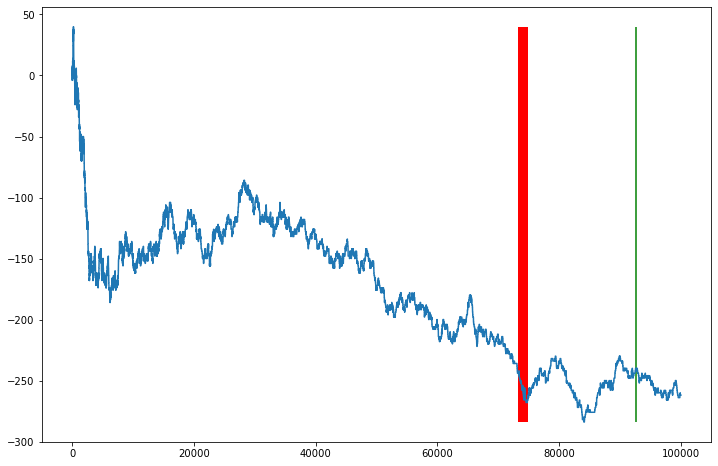

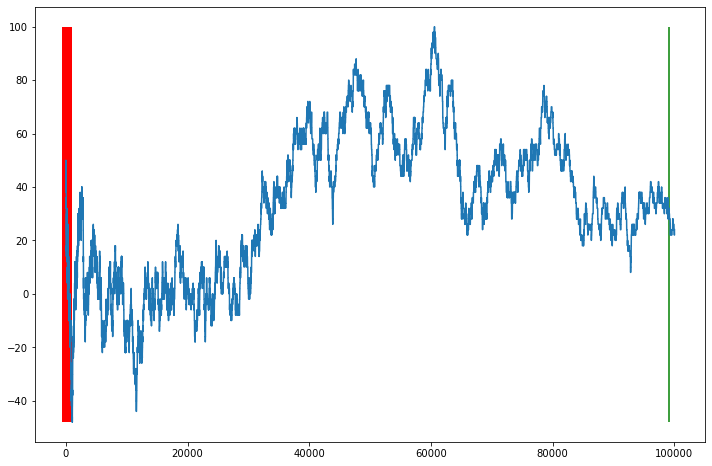

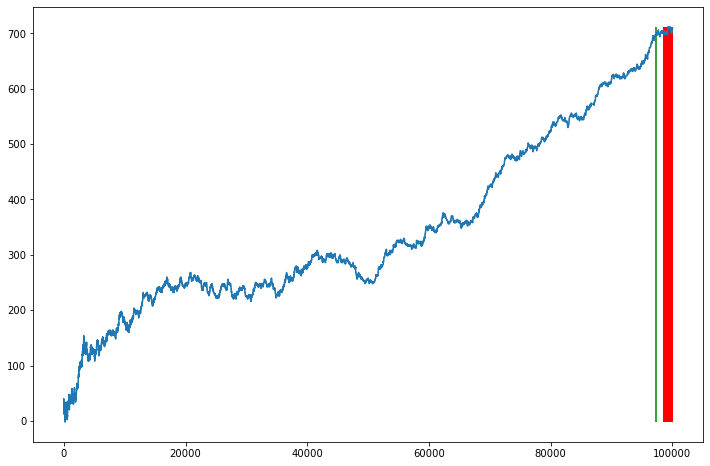

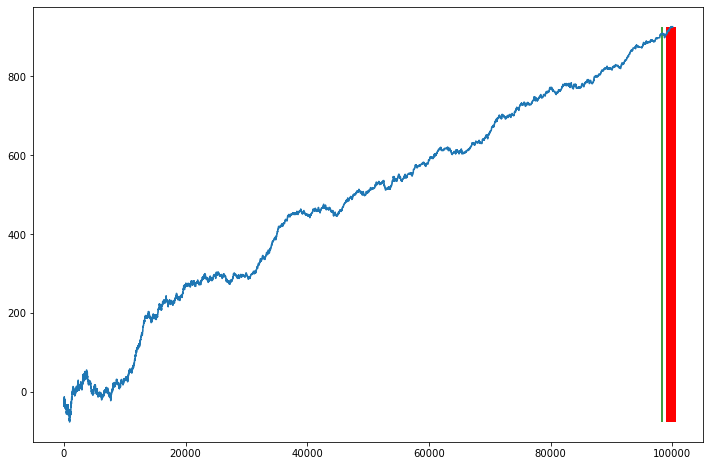

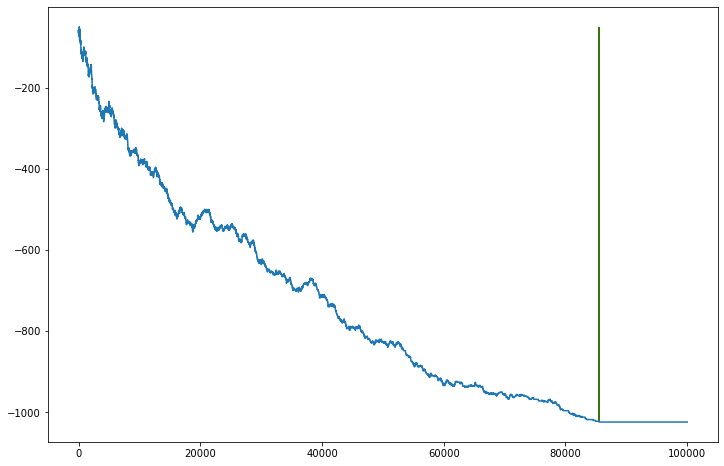

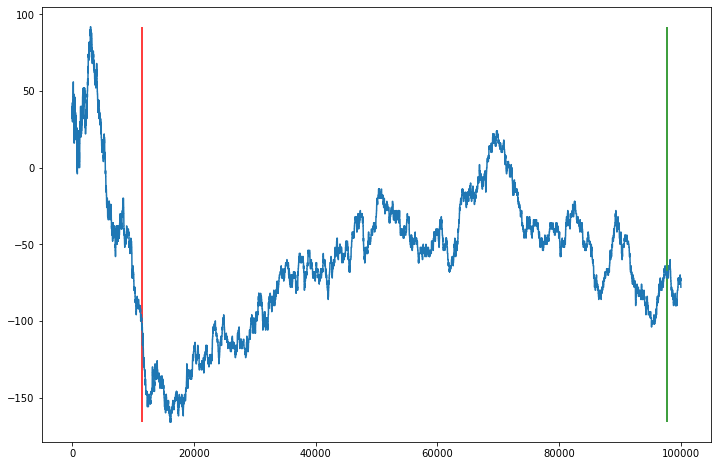

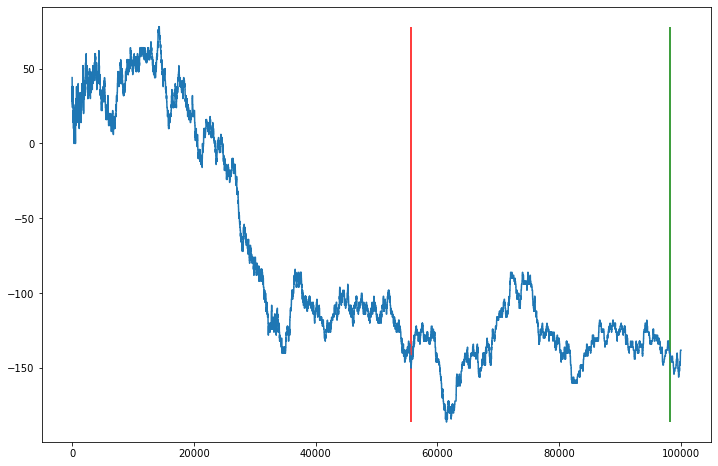

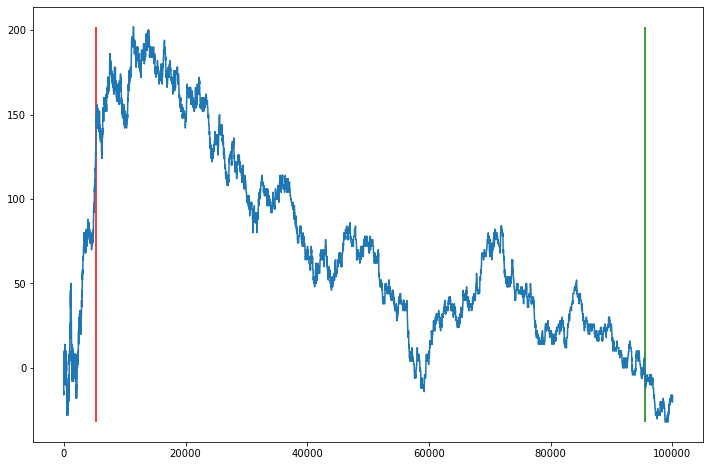

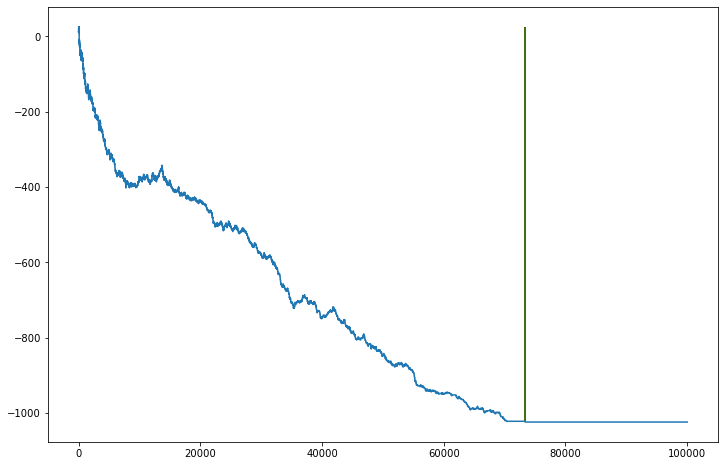

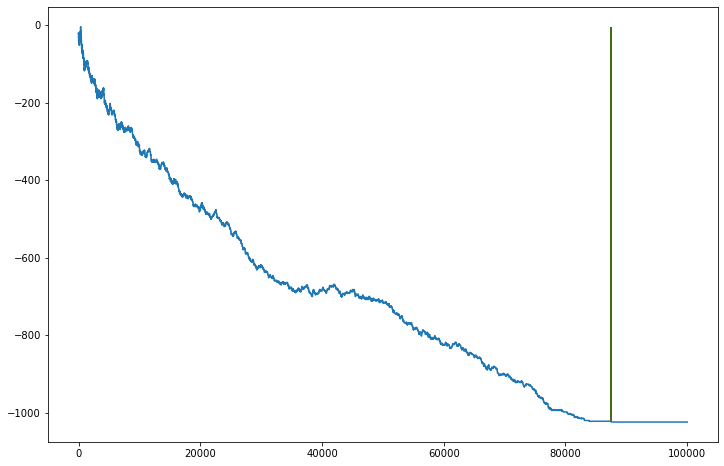

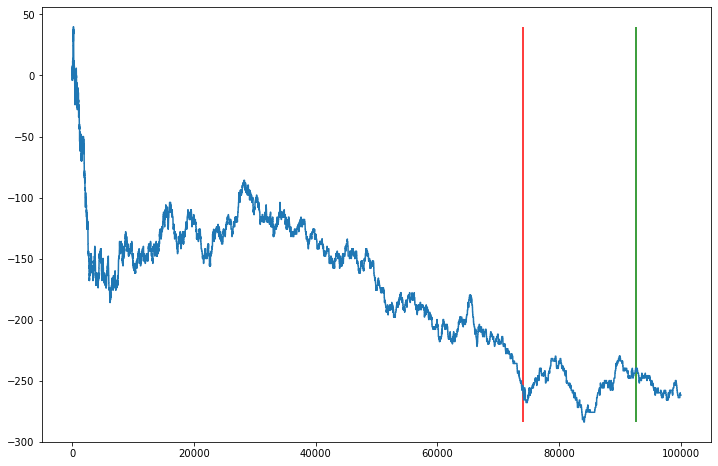

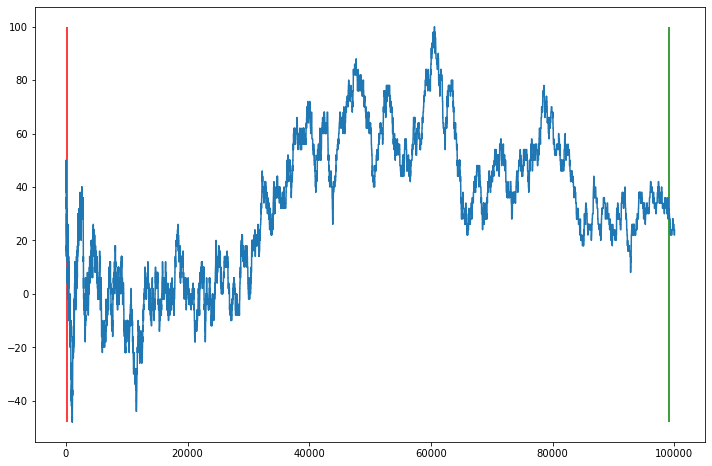

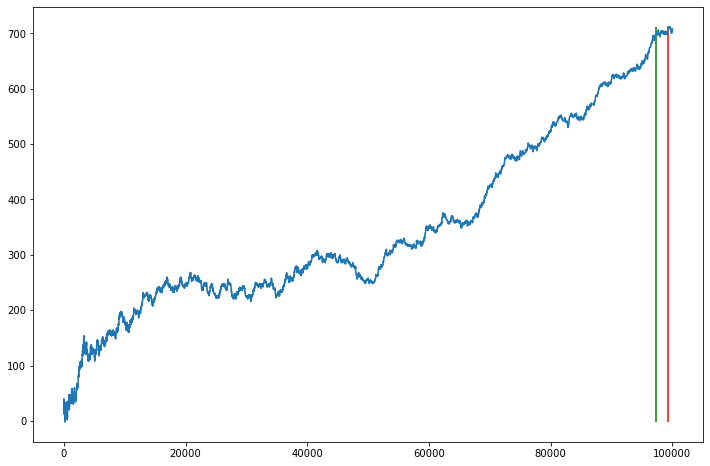

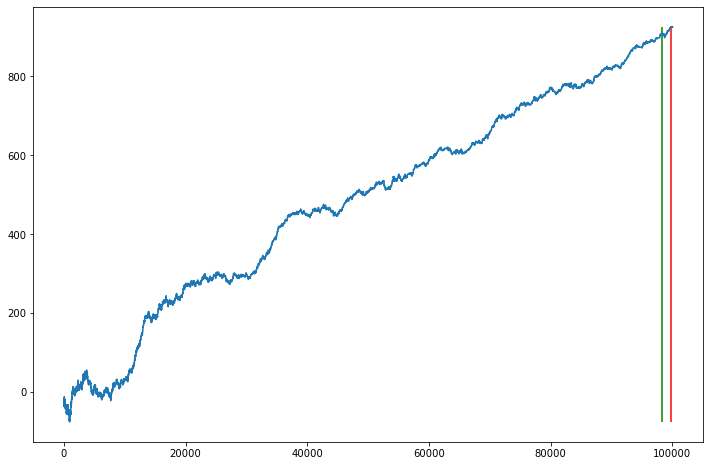

In [163]:
for Ms, Es in zip(Mss_rand, Ess_rand):
    plt.figure()
    plt.plot(Ms)
    pos = findpos(Ms)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="r", lw=10)
    pos = findpos(Es)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="g")
    
    
for Ms, Es in zip(Mss_rand, Ess_rand):
    plt.figure()
    plt.plot(Ms)
    pos = findpos(Ms)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="r")
    pos = findpos(Es)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="g")

In [103]:
Ms = Mss_rand[4]

In [54]:
Ms = Mss_const[4]

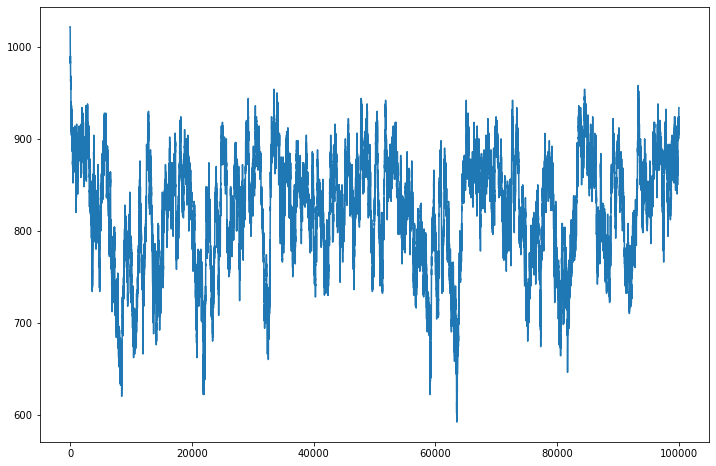

In [59]:
plt.plot(Ms)

In [64]:
np.mean(Ms)

822.91476

In [96]:
findpos(Ms)

(array([ 5531,  5532,  5533, ..., 88733, 88734, 88770], dtype=int64),)
(array([ 5532,  5533,  5534, ..., 88731, 88732, 88733], dtype=int64),)
(array([ 5532,  5533,  5534, ..., 88731, 88732, 88733], dtype=int64),)


5532

In [50]:
pos = [0]
for _ in range(400):
    pos.append(findpos(Ms, start=pos[-1]))
    if pos[-1]==pos[-2]:
        break

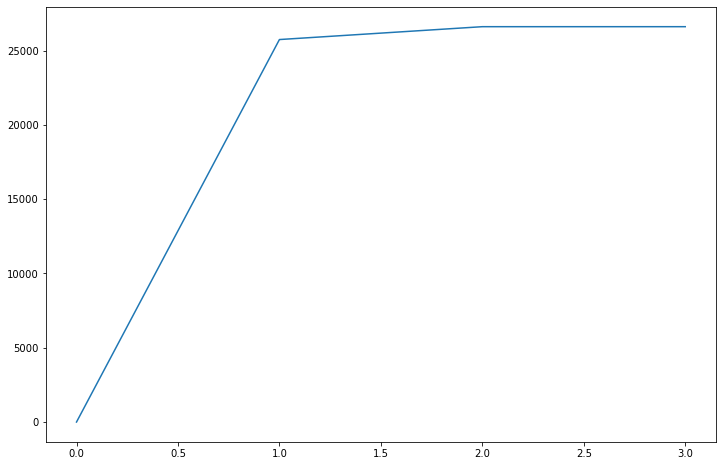

In [51]:
plt.plot(pos)

In [38]:
findpos(Ms, 4524)

4901

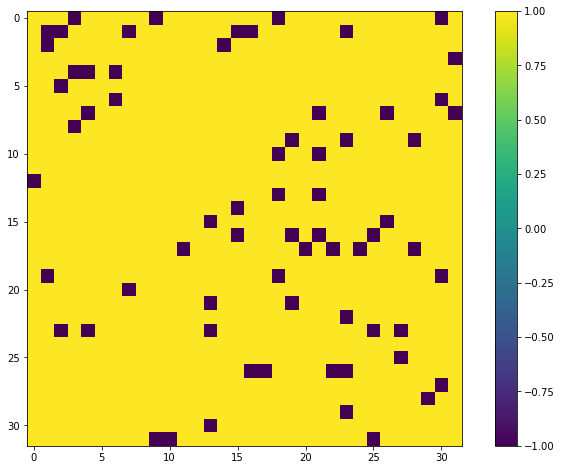

In [18]:
plt.imshow(engine.get_state())
plt.colorbar()